## NN Overfitting and How to Fix It

##### Credits: [Radoslav Neychev](https://www.linkedin.com/in/radoslav-neychev/), @neychev

In [80]:
# do not change the code in the block below
# __________start of block__________
from collections import OrderedDict
import json
import os
import re

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST

# __________end of block__________

In [81]:
# do not change the code in the block below
# __________start of block__________

def parse_pytorch_model(model, device):
    H, W = 28, 28
    sample_input = torch.randn(1, 1, H, W).to(device=device)
    supported_modules = [
        nn.Linear, nn.Flatten, nn.Dropout, nn.Dropout2d,
        nn.ReLU, nn.LeakyReLU,
        nn.Conv1d, nn.Conv2d,
        nn.BatchNorm1d, nn.BatchNorm2d,
        nn.MaxPool2d, nn.AvgPool2d,
        nn.AdaptiveAvgPool2d, nn.AdaptiveMaxPool2d,
    ]
    def register_hook(module):
        def hook(module, input, output):
            module_idx = len(model_dict["layers"])
            if any([isinstance(module, instance) for instance in supported_modules]):
                model_dict["layers"].append(
                    {
                        "index": module_idx,
                        "layer": {
                            "type": module.__class__.__name__,
                            "params": str(module),
                        }
                    }
                )
        if (
            not isinstance(module, nn.Sequential)
            and not isinstance(module, nn.ModuleList)
        ):
            hooks.append(module.register_forward_hook(hook))

    model_dict = {
        "model_name": model.__class__.__name__,
        "layers": []
    }
    hooks = []
    model.apply(register_hook)
    _ = model(sample_input)
    # remove hooks
    for h in hooks:
        h.remove()
    return model_dict

# __________end of block__________

In [82]:
# do not change the code in the block below
# __________start of block__________
def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels


def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score


# __________end of block__________

Load file `hw_overfitting_data_dict.npy` (link is on the task page), it will be used to generate submissions. Code below helps to load it (in case error occurs, download the file manually).


In [83]:
!wget https://github.com/girafe-ai/ml-course/blob/26s_harbour/homeworks/hw005_fmnist/hw_overfitting_data_dict.npy

--2025-12-16 16:35:39--  https://github.com/girafe-ai/ml-course/blob/26s_harbour/homeworks/hw005_fmnist/hw_overfitting_data_dict.npy
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘hw_overfitting_data_dict.npy.5’

hw_overfitting_data     [ <=>                ] 181.29K  1022KB/s    in 0.2s    

2025-12-16 16:35:40 (1022 KB/s) - ‘hw_overfitting_data_dict.npy.5’ saved [185639]



In [84]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

# __________end of block__________

### Task #1: Creating and training a model (Separation)
Let's go back to the simple image classification task which was discussed earlier. But now we will utilize the [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. Let's use full dataset fot this task.

__Your first task: implement the entire model training pipeline and reach accuracy baseline of $\geq 88.5\%$ on the test set.__

There is no code for training the model in this task. There are only a few tests that will help you debug your solution. You may use notebook practice from previous class as a reference.

In [85]:
CUDA_DEVICE_ID = 0  # change if needed

In [86]:
# do not change the code in the block below
# __________start of block__________
device = (
    torch.device(f"cuda:{CUDA_DEVICE_ID}") if torch.cuda.is_available() else torch.device("cpu")
)
# __________end of block__________

Text(0.5, 1.0, 'Image label: 7')

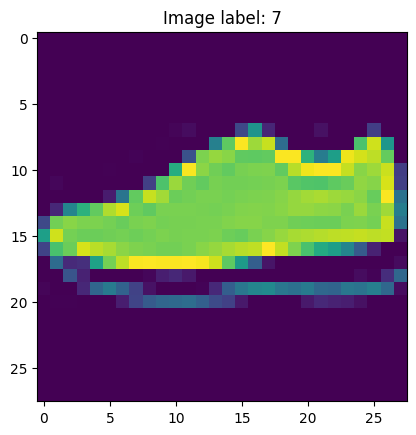

In [87]:
# do not change the code in the block below
# __________start of block__________

train_fmnist_data = FashionMNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_fmnist_data = FashionMNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)


train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data, batch_size=32, shuffle=False, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

Define your model in the code block below. Please don't make it too complicated, don't use more than 4 layers (it can be even less actually). Your main goal is to train the model and exceed `accuracy` baseline of 88.5%.

__ATTENTION, your model has to be defined in `model_task_1` variable. It should use batches of input tensors of shape (1, 28, 28).__

In [88]:
# Creating model instance
model_task_1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)


Don't forget to move your model to the `device`!

In [89]:
model_task_1.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=10, bias=True)
)

Local unit tests for sanity check are given below:

In [90]:
# do not change the code in the block below
# __________start of block__________
assert model_task_1 is not None, "Please, use `model_task_1` variable to store your model"

try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model_task_1(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")
# __________end of block__________

Everything seems fine!


Set up model hyperparameters for training. It's worth adjusting `learning rate` parameter as well.

In [91]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_task_1.parameters(), lr=0.0005)
num_epochs = 10
for epoch in range(num_epochs):
    model_task_1.train()
    total_loss = 0
    for batch in train_data_loader:
      x, y = batch[0].to(device), batch[1].to(device)
      optimizer.zero_grad()
      y_predicted = model_task_1(x)
      loss = criterion(y_predicted, y)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_data_loader):.4f}')


Epoch 1/10, Loss: 0.5286
Epoch 2/10, Loss: 0.3721
Epoch 3/10, Loss: 0.3317
Epoch 4/10, Loss: 0.3065
Epoch 5/10, Loss: 0.2889
Epoch 6/10, Loss: 0.2729
Epoch 7/10, Loss: 0.2575
Epoch 8/10, Loss: 0.2472
Epoch 9/10, Loss: 0.2349
Epoch 10/10, Loss: 0.2243


Don't forget to read the great [docs](https://pytorch.org/docs/stable/index.html) and [tutorials](https://pytorch.org/tutorials/).  

Evaluate accuracy:

In [92]:
train_acc_task_1 = get_accuracy(model_task_1, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_1:3.5}")

Neural network accuracy on train set: 0.92378


In [93]:
test_acc_task_1 = get_accuracy(model_task_1, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_1:3.5}")

Neural network accuracy on test set: 0.8897


Asserts for passing accuracy baseline:

In [94]:
assert test_acc_task_1 >= 0.885, "Train accuracy is below 0.885 threshold"
assert (
    train_acc_task_1 >= 0.905
), "Test accuracy is below 0.905 while test accuracy is fine. We recommend to check your model and data flow"

Note that code below expected your model to be defined in `model_task_1` variable.

In [98]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict = {
    "train_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["train"])
    ),
    "test_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["test"])
    ),
    "model_task_1": parse_pytorch_model(model_task_1, device),
}

with open("submission_dict_task_1.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_task_1.json`")
# __________end of block__________

File saved to `submission_dict_task_1.json`


In [101]:
import os
print(os.listdir())


['.config', 'hw_overfitting_data_dict.npy', 'submission_dict_task_1.json', 'FashionMNIST', '.ipynb_checkpoints', 'sample_data']


### Task #2: Overfitting (Initiation)
We're still working with the [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. Now the task is to demonstrate model overfitting on the training set. In other words we need to demonstrate classification accuracy (not the loss value!), which is significantly higher for the training set in comparison with the testing set.

Please note that in task #3 you will have to fix this model (reduce overfitting) using regularization, so don't overdo it!

__Your second task: implement model training pipeline to demonstrate model ovefitting for the training set.__

You can reuse some training code from above. There are a few tests further to help you check your solution.

Note that for this task model has to be defined in variable `model_task_2`.

Don't use `Dropout` and `BatchNorm` for this task.

In [99]:
# Creating model instance
model_task_2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10))


In [102]:
import torch.optim as optim
model_task_2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_task_2.parameters(), lr=0.001)
num_epochs = 20
for epoch in range(num_epochs):
    model_task_2.train()
    total_loss = 0
    for batch in train_data_loader:
        x, y = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        y_predicted = model_task_2(x)
        loss = criterion(y_predicted, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_data_loader):.4f}')


Epoch 1/20, Loss: 0.5058
Epoch 2/20, Loss: 0.3673
Epoch 3/20, Loss: 0.3289
Epoch 4/20, Loss: 0.3044
Epoch 5/20, Loss: 0.2848
Epoch 6/20, Loss: 0.2713
Epoch 7/20, Loss: 0.2562
Epoch 8/20, Loss: 0.2483
Epoch 9/20, Loss: 0.2333
Epoch 10/20, Loss: 0.2268
Epoch 11/20, Loss: 0.2166
Epoch 12/20, Loss: 0.2111
Epoch 13/20, Loss: 0.2017
Epoch 14/20, Loss: 0.1967
Epoch 15/20, Loss: 0.1932
Epoch 16/20, Loss: 0.1843
Epoch 17/20, Loss: 0.1819
Epoch 18/20, Loss: 0.1733
Epoch 19/20, Loss: 0.1721
Epoch 20/20, Loss: 0.1643


NN architecture check:

In [103]:
# do not change the code in the block below
# __________start of block__________
layers_task_2 = []
for element in parse_pytorch_model(model_task_2, device).get("layers", []):
    layer_name = element["layer"]["type"]
    assert "dropout" not in layer_name.lower(), "Do not use Dropout in Task 2!"
    assert "batchnorm" not in layer_name.lower(), "Do not use BatchNorm in Task 2!"
    layers_task_2.append(layer_name)
# __________end of block__________

Estimate accuracy:

In [104]:
train_acc_task_2 = get_accuracy(model_task_2, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_2:3.5}")

Neural network accuracy on train set: 0.93875


In [105]:
test_acc_task_2 = get_accuracy(model_task_2, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_2:3.5}")

Neural network accuracy on test set: 0.8883


Test that there is definitely overfitting:

In [106]:
assert train_acc_task_2 >= test_acc_task_2, "Train accuracy must be higher than task accuracy"
assert train_acc_task_2 >= 0.88, "Train accuracy must be higher than 0.88"
assert (
    train_acc_task_2 - test_acc_task_2 >= 0.04
), "Test accuracy should be at least 0.04 lower that train."

Note once again that for the code below to work your model has to be defined in `model_task_2` variable.

Also note that `submission_dict` variable already has saved results from task #1. If it does not, reload them from the saved file to this variable before running the next cell.

In [107]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict.update(
    {
        "train_predictions_task_2": get_predictions(
            model_task_2, torch.FloatTensor(loaded_data_dict.item()["train"])
        ),
        "test_predictions_task_2": get_predictions(
            model_task_2, torch.FloatTensor(loaded_data_dict.item()["test"])
        ),
        "model_task_2": parse_pytorch_model(model_task_2, device),
    }
)

with open("submission_dict_tasks_1_and_2.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_tasks_1_and_2.json`")
# __________end of block__________

File saved to `submission_dict_tasks_1_and_2.json`


### Task #3: Fix the model (Return)
We're still working with [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Finally, let's fix overfitting issue for the model from task#2. By fixing it means to achieve classification accuracy difference of 0.015 (=1.5%) for training and testing accuracy using a new updated model.

Note that model architecture in task#3 should not be very different from task#2! You can use Batchnorm, Dropout, data augmentation and also reduce the channel number. You can not reduce the number of layers!


__Your third and final task: fix the model and/or training pipeline to fix overfitting.__

Once again you can reuse model training code. As usual there are a few tests below for sanity check.

Note that for this task model has to be defined in variable `model_task_3`.

Code below will also access `layers_task_2` variable. Define it if it was not defined before.

In [186]:
model_task_3 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 10)
)
model_task_3.to(device)


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.3, inplace=False)
  (7): Linear(in_features=128, out_features=64, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.3, inplace=False)
  (10): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_task_3.parameters(), lr=0.0005, weight_decay=2e-4)
num_epochs = 20
for epoch in range(num_epochs):
    model_task_3.train()
    total_loss = 0
    for batch in train_data_loader:
        x, y = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        y_predicted = model_task_3(x)
        loss = criterion(y_predicted, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_data_loader):.4f}')

Check NN architecture:

In [200]:
# do not change the code in the block below
# __________start of block__________
layers_task_3 = []
for element in parse_pytorch_model(model_task_3, device).get("layers", []):
    layer_name = element["layer"]["type"]
    layers_task_3.append(layer_name)

idx = 0
for model_3_layer in layers_task_3:
    model_2_layer = layers_task_2[idx]
    if "dropout" not in model_3_layer.lower() and "batchnorm" not in model_3_layer.lower():
        assert (
            model_3_layer == model_2_layer
        ), "Models in tasks 2 and 3 must share the architecture except for Dropout and BatchNorm!"
        idx += 1
# __________end of block__________

Estimate classification accuracy:

In [201]:
train_acc_task_3 = get_accuracy(model_task_3, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_3:3.5}")

Neural network accuracy on train set: 0.92262


In [202]:
test_acc_task_3 = get_accuracy(model_task_3, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_3:3.5}")

Neural network accuracy on test set: 0.8884


Check if overfitting is still here:

In [197]:
assert train_acc_task_3 >= 0.88, "Train accuracy must be higher than 0.88"
assert train_acc_task_3 >= 0.865, "Test accuracy must be higher than 0.865"
assert (
    train_acc_task_3 - test_acc_task_3 <= 0.015
), "Test accuracy should not be lower that train more than by 0.015"

AssertionError: Test accuracy should not be lower that train more than by 0.015

Note that code below thinks that your model is defined in variable `model_task_3`.

Also note that `submission_dict` variable should already have saved results from tasks #1 and #2. If it does not, reload them from the saved files before running the next cell.

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict.update(
    {
        "train_predictions_task_3": get_predictions(
            model_task_3, torch.FloatTensor(loaded_data_dict.item()["train"])
        ),
        "test_predictions_task_3": get_predictions(
            model_task_3, torch.FloatTensor(loaded_data_dict.item()["test"])
        ),
        "model_task_3": parse_pytorch_model(model_task_3, device),
    }
)

with open("submission_dict_final.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_final.json`")
# __________end of block__________

### Submit the results for automatic grading
Submit generated files to the corresponding contest tasks:
    
* `submission_dict_task_1.json` to Separation
* `submission_dict_tasks_1_and_2.json` to Initiation
* `submission_dict_final.json` to Return.

The task is finished! Congrats!